<a href="https://colab.research.google.com/github/dhanmoti/ml-exercise/blob/smu-fnce685-project/SMU_FNCE685_G2_PD_Prediction_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Define the Problem & **Objectives**
## Objective
* **Static PD Model**: Predicts probability of default (PD) at loan origination based on borrower characteristics at application.

* **Dynamic PD Model**: Adjusts PD over time by incorporating loan performance trends and changing borrower behavior.

### Hypothesis
A dynamic PD model provides better predictions by adapting to changing borrower conditions, whereas a static model can only be used at loan origination stage.

# Install & Import

In [258]:
# Install packages if required
#!pip install -q kaggle
#!pip install xgboost catboost

In [259]:
# Import
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')


In [260]:
 # Setting up kaggle
# from google.colab import files

# files.upload()
# ! mkdir ~/.kaggle

#! cp kaggle.json ~/.kaggle/

In [261]:
#! chmod 600 ~/.kaggle/kaggle.json

In [262]:
# Download Kaggle data
#! kaggle competitions download -c loan-default-pred

In [263]:
#!unzip loan-default-pred.zip

# Reusable Functions

In [264]:
def plot_correlation_heatmap(df, annot=False, figsize=(12, 8), cmap="coolwarm", linewidths=0.5, columns_subset=None):
    """
    Plots a heatmap of the correlation matrix for the given DataFrame.

    Parameters:
        df (pandas.DataFrame): The input DataFrame.
        annot (bool): Whether to display correlation coefficients.
                      Disabling it (annot=False) can speed up rendering.
        figsize (tuple): Size of the figure.
        cmap (str): Colormap.
        linewidths (float): Width of the lines that will divide each cell.
        columns_subset (list or None): If provided, only these columns will be used to compute the correlation.

    Returns:
        None: Displays the heatmap.
    """
    # If a subset of columns is provided, use it; otherwise, select numeric columns.
    if columns_subset is not None:
        data = df[columns_subset]
    else:
        data = df.select_dtypes(include=[np.number])

    # Compute the correlation matrix.
    corr_matrix = data.corr()

    # Create the heatmap.
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=annot, fmt=".2f", cmap=cmap, linewidths=linewidths)
    plt.title("Feature Correlation Heatmap")
    plt.show()

In [265]:
import numpy as np
import pandas as pd

def drop_highly_correlated_features(df, threshold=0.75):
    """
    Drops features from the DataFrame that are highly correlated with others using a vectorized approach.

    Parameters:
        df (pandas.DataFrame): The input DataFrame.
        threshold (float): The correlation threshold above which a feature is dropped.
                           (Default is 0.75)

    Returns:
        new_df (pandas.DataFrame): A new DataFrame with highly correlated features removed.
        dropped_features (list): A list of the feature names that were dropped.
    """
    # Compute the correlation matrix and take the absolute value
    corr_matrix = df.corr().abs()

    # Create a mask for the upper triangle (excluding the diagonal)
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identify columns to drop: any column with a correlation value greater than the threshold
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

    # Drop these columns from the DataFrame
    new_df = df.drop(columns=to_drop)

    return new_df, to_drop

In [266]:
def preprocess_dataframe(df):
    """
    Preprocess the DataFrame by performing the following:
      1. Drop unnecessary columns.
      2. Convert interest rate ('int_rate') from a percentage string to float.
      3. Convert date columns ('issue_d' and 'last_pymnt_d') to datetime.
      4. Label encode specified ordinal columns.
      5. One-hot encode any remaining categorical columns.

    Parameters:
      df (pandas.DataFrame): The input DataFrame.

    Returns:
      df_encoded (pandas.DataFrame): The preprocessed DataFrame.
      label_encoders (dict): Dictionary of fitted label encoders for ordinal columns.
    """
    # Work on a copy to avoid modifying the original DataFrame.
    df_processed = df.copy()

    # 1. Drop unnecessary columns (ignore if any are missing).
    cols_to_drop = ['id', 'member_id', 'url', 'desc', 'title', 'emp_title', 'zip_code', 'mths_since_last_record', 'mths_since_last_delinq', 'addr_state']
    df_processed.drop(columns=cols_to_drop, errors='ignore', inplace=True)

    # 2. Convert interest rate from percentage string to float.
    if 'int_rate' in df_processed.columns:
        df_processed['int_rate'] = df_processed['int_rate'].str.rstrip('%').astype(float)
    #2.1
    if 'revol_util' in df_processed.columns:
        df_processed['revol_util'] = df_processed['revol_util'].str.rstrip('%').astype(float)

    # 3. Convert date columns to datetime objects.
    date_columns = {
         'issue_d': '%b-%y',
         'last_pymnt_d': '%b-%y',
         'last_credit_pull_d': '%b-%y',
         'earliest_cr_line': '%b-%y'
    }
    for col, date_format in date_columns.items():
        if col in df_processed.columns:
            df_processed[col] = pd.to_datetime(df_processed[col], format=date_format)

    # 3.1 Convert date to ordinal numerical data
    df_processed = convert_datetime_columns(df_processed, method='ordinal')


    # 4. Label encode specified ordinal columns.
    ordinal_columns = ['term', 'grade', 'sub_grade', 'emp_length']
    label_encoders = {}
    for col in ordinal_columns:
        if col in df_processed.columns:
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col])
            label_encoders[col] = le

    # 5. Identify any remaining categorical columns and apply one-hot encoding.
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    print("Categorical Columns for one-hot encoding:", list(categorical_cols))
    df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

    # Optional: Check conversion of date columns if they exist.
    if 'issue_d' in df_encoded.columns and 'last_pymnt_d' in df_encoded.columns:
        print("Date conversion check:")
        print(df_encoded[['issue_d', 'last_pymnt_d']].head())

    return df_encoded, label_encoders

# Example usage:
# df = pd.read_csv('your_dataset.csv')
# df_preprocessed, encoders = preprocess_dataframe(df)
# df_preprocessed.head()


In [267]:
import pandas as pd

def handle_missing_values(df, method='fill', numeric_strategy='median', categorical_strategy='mode'):
    """
    Handles missing values in the DataFrame.

    Parameters:
        df (pandas.DataFrame): The input DataFrame.
        method (str): Method to handle missing values. Options:
                      'fill' (default) to fill missing values,
                      'drop' to drop rows with missing values.
        numeric_strategy (str): Strategy for numeric columns when method='fill'.
                                Options: 'median' (default) or 'mean'.
        categorical_strategy (str): Strategy for categorical columns when method='fill'.
                                    Options: 'mode' (default). If another value is provided,
                                    missing values will be filled with the string "Missing".

    Returns:
        pandas.DataFrame: A new DataFrame with missing values handled.
    """
    df_handled = df.copy()

    if method == 'fill':
        # Fill numeric columns.
        numeric_cols = df_handled.select_dtypes(include=['number']).columns
        for col in numeric_cols:
            if numeric_strategy == 'median':
                df_handled[col].fillna(df_handled[col].median(), inplace=True)
            elif numeric_strategy == 'mean':
                df_handled[col].fillna(df_handled[col].mean(), inplace=True)
            else:
                raise ValueError("Invalid numeric_strategy. Use 'median' or 'mean'.")

        # Fill categorical columns.
        categorical_cols = df_handled.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if categorical_strategy == 'mode':
                # Use the most frequent value.
                df_handled[col].fillna(df_handled[col].mode()[0], inplace=True)
            else:
                # Fill with a custom string if desired.
                df_handled[col].fillna("Missing", inplace=True)

    elif method == 'drop':
        df_handled.dropna(inplace=True)
    else:
        raise ValueError("Invalid method. Use 'fill' or 'drop'.")

    return df_handled

# Example usage:
# df = pd.read_csv('your_dataset.csv')
# df_clean = handle_missing_values(df, method='fill', numeric_strategy='median', categorical_strategy='mode')
# df_clean.info()


In [268]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

def run_lasso_feature_selection(df, target, test_size=0.2, random_state=42):
    """
    Splits the dataset, applies LassoCV for feature selection and regression,
    prints and returns the selected features and test set performance.

    Parameters:
        df (pandas.DataFrame): Input DataFrame with features and target.
        target (str): Name of the target column.
        test_size (float): Fraction of data to use as test set (default is 0.2).
        random_state (int): Random seed for reproducibility (default is 42).

    Returns:
        lasso_cv (LassoCV): The fitted LassoCV model.
        selected_features (list): List of feature names with non-zero coefficients.
        mse (float): Mean Squared Error on the test set.
    """
    # Separate features and target
    X = df.drop(columns=[target])
    y = df[target]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        random_state=random_state)

    # Standardize Features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    # Apply Lasso with cross-validation to find the optimal regularization parameter
    alphas = np.logspace(-5, 0, 200)  # Experiment with a wider range of alphas
    lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=random_state)
    lasso_cv.fit(X_train, y_train)

    # Identify features with non-zero coefficients
    selected_features = X.columns[lasso_cv.coef_ != 0]
    print("Selected features:", list(selected_features))

    # Evaluate performance on the test set
    y_pred = lasso_cv.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    return lasso_cv, list(selected_features), mse

# Example usage:
# df = pd.read_csv('your_dataset.csv')
# model, features, error = run_lasso_feature_selection(df, target='target')


In [269]:
import pandas as pd

def convert_datetime_columns(df, method='ordinal'):
    """
    Convert all datetime columns in a DataFrame to numeric values.

    Parameters:
        df (pandas.DataFrame): The input DataFrame.
        method (str): Conversion method. Options:
                      'ordinal' - converts to ordinal (days count) using toordinal().
                      'unix' - converts to Unix timestamp (seconds since epoch).

    Returns:
        df (pandas.DataFrame): The DataFrame with datetime columns converted to numeric values.
    """
    datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
    for col in datetime_cols:
        if method == 'ordinal':
            # Convert each datetime to its ordinal if not null; otherwise, return None
            df[col] = df[col].apply(lambda x: x.toordinal() if pd.notnull(x) else None)
        elif method == 'unix':
            # Convert each datetime to a Unix timestamp if not null; otherwise, return None
            df[col] = df[col].apply(lambda x: int(x.timestamp()) if pd.notnull(x) else None)
        else:
            raise ValueError("Invalid method. Choose 'ordinal' or 'unix'.")
    return df

# Example usage:
# Assuming X_train and X_test are your training and testing DataFrames containing datetime columns:
# X_train = convert_datetime_columns(X_train, method='ordinal')
# X_test = convert_datetime_columns(X_test, method='ordinal')


In [270]:
def standardize_numerical_features(X):
  # Scale numerical features [split first. do it on train set]
  scaler = StandardScaler()
  numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
  X[numeric_columns] = scaler.fit_transform(X[numeric_columns])
  return X

# Load

In [271]:
# Load dataset
df_train = pd.read_csv("/content/loan_train.csv")

## Check Data Types & Convert Columns if Needed


In [272]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       27003 non-null  int64  
 1   member_id                27003 non-null  int64  
 2   loan_amnt                27003 non-null  int64  
 3   funded_amnt              27003 non-null  int64  
 4   funded_amnt_inv          27003 non-null  float64
 5   term                     27003 non-null  object 
 6   int_rate                 27003 non-null  object 
 7   installment              27003 non-null  float64
 8   grade                    27003 non-null  object 
 9   sub_grade                27003 non-null  object 
 10  emp_title                25321 non-null  object 
 11  emp_length               26273 non-null  object 
 12  home_ownership           27003 non-null  object 
 13  annual_inc               27003 non-null  float64
 14  verification_status   

In [273]:
df_preprocessed_train, encoders = preprocess_dataframe(df_train)
df_preprocessed_train.head()

Categorical Columns for one-hot encoding: ['home_ownership', 'verification_status', 'purpose']
Date conversion check:
   issue_d  last_pymnt_d
0   733954      734747.0
1   734016      734989.0
2   733712      734258.0
3   734228      735050.0
4   734472      735112.0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,10000,10000,9975.0,0,13.23,338.05,2,10,4,37000.0,...,False,False,False,False,False,False,False,False,False,False
1,14000,14000,13775.0,0,7.88,437.94,0,4,10,105000.0,...,False,False,False,False,False,False,False,False,False,False
2,9475,9475,9475.0,0,8.94,301.04,0,4,9,27000.0,...,False,False,False,False,False,False,False,False,False,False
3,4000,4000,4000.0,0,7.29,124.04,0,3,1,35000.0,...,False,False,False,False,False,False,False,False,False,False
4,3600,3600,3600.0,0,6.62,110.54,0,1,0,60000.0,...,False,False,False,False,False,False,False,False,False,False


In [274]:
df_preprocessed_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Data columns (total 53 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            27003 non-null  int64  
 1   funded_amnt                          27003 non-null  int64  
 2   funded_amnt_inv                      27003 non-null  float64
 3   term                                 27003 non-null  int64  
 4   int_rate                             27003 non-null  float64
 5   installment                          27003 non-null  float64
 6   grade                                27003 non-null  int64  
 7   sub_grade                            27003 non-null  int64  
 8   emp_length                           27003 non-null  int64  
 9   annual_inc                           27003 non-null  float64
 10  issue_d                              27003 non-null  int64  
 11  loan_status                 

# Cleaning data

In [275]:
# Calculate percentage of missing values for each column
missing_percent = df_preprocessed_train.isnull().mean() * 100

# Create a DataFrame to display the results neatly
missing_table = pd.DataFrame({
    'Column': missing_percent.index,
    'Missing Percentage': missing_percent.values
})

# Sort the table by missing percentage (highest first) and display it
missing_table.sort_values(by='Missing Percentage', ascending=False, inplace=True)
print(missing_table)

                                 Column  Missing Percentage
33                 pub_rec_bankruptcies            1.862756
30                         last_pymnt_d            0.188868
19                           revol_util            0.129615
32                   last_credit_pull_d            0.003703
0                             loan_amnt            0.000000
39         verification_status_Verified            0.000000
29              collection_recovery_fee            0.000000
31                      last_pymnt_amnt            0.000000
34                  home_ownership_NONE            0.000000
35                 home_ownership_OTHER            0.000000
36                   home_ownership_OWN            0.000000
37                  home_ownership_RENT            0.000000
38  verification_status_Source Verified            0.000000
40                  purpose_credit_card            0.000000
27                   total_rec_late_fee            0.000000
41           purpose_debt_consolidation 

In [276]:
# df_train_clean = handle_missing_values(df_preprocessed_train, method='drop', numeric_strategy='median', categorical_strategy='mode')
df_train_clean = handle_missing_values(df_preprocessed_train, method='fill', numeric_strategy='median', categorical_strategy='mode')
df_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Data columns (total 53 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            27003 non-null  int64  
 1   funded_amnt                          27003 non-null  int64  
 2   funded_amnt_inv                      27003 non-null  float64
 3   term                                 27003 non-null  int64  
 4   int_rate                             27003 non-null  float64
 5   installment                          27003 non-null  float64
 6   grade                                27003 non-null  int64  
 7   sub_grade                            27003 non-null  int64  
 8   emp_length                           27003 non-null  int64  
 9   annual_inc                           27003 non-null  float64
 10  issue_d                              27003 non-null  int64  
 11  loan_status                 

In [277]:
df_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Data columns (total 53 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            27003 non-null  int64  
 1   funded_amnt                          27003 non-null  int64  
 2   funded_amnt_inv                      27003 non-null  float64
 3   term                                 27003 non-null  int64  
 4   int_rate                             27003 non-null  float64
 5   installment                          27003 non-null  float64
 6   grade                                27003 non-null  int64  
 7   sub_grade                            27003 non-null  int64  
 8   emp_length                           27003 non-null  int64  
 9   annual_inc                           27003 non-null  float64
 10  issue_d                              27003 non-null  int64  
 11  loan_status                 

## Display correlation matrix



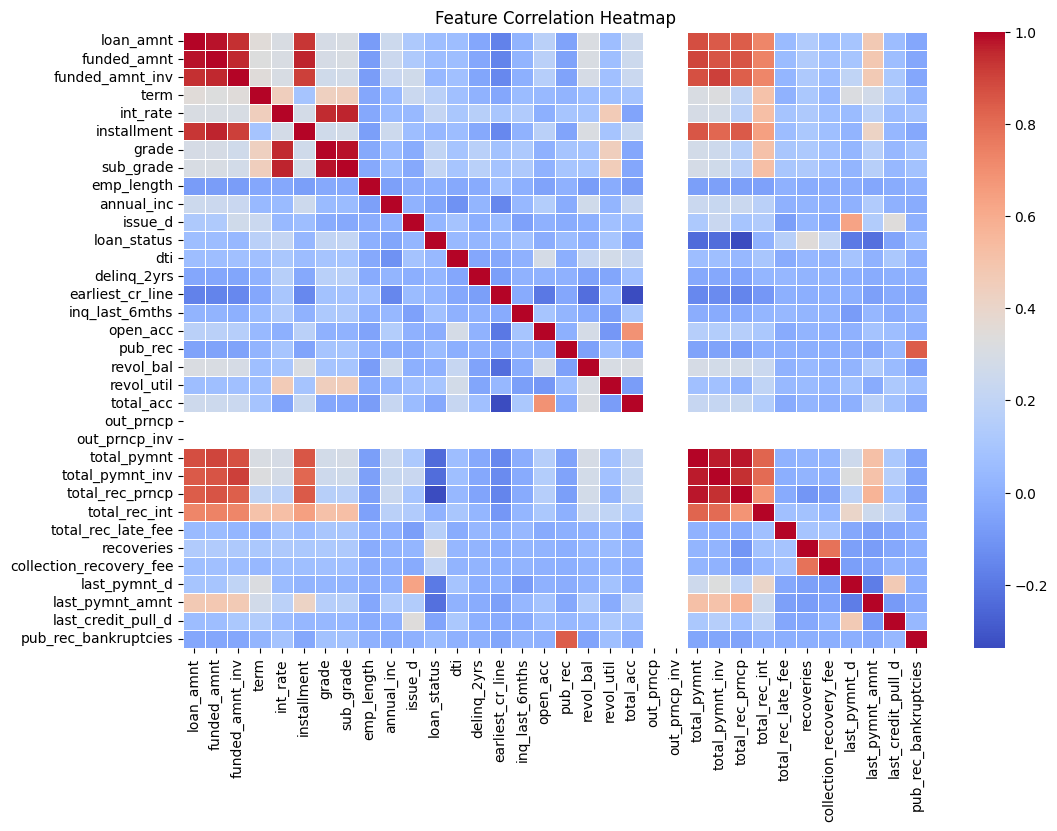

In [278]:
# [!Warning] Too slow
# Show correlation matrix
plot_correlation_heatmap(df_train_clean)

In [279]:
# [!Warning] Too slow
# Drop drop_highly_correlated_features
df_train_clean_drop_hicorr, dropped = drop_highly_correlated_features(df_train_clean, threshold=0.75)
df_train_clean_drop_hicorr.head()

,loan_amnt,term,int_rate,emp_length,annual_inc,issue_d,loan_status,dti,delinq_2yrs,earliest_cr_line,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,10000,0,13.23,4,37000.0,733954,0,16.86,0,731094,...,False,False,False,False,False,False,False,False,False,False
1,14000,0,7.88,10,105000.0,734016,0,6.33,0,732128,...,False,False,False,False,False,False,False,False,False,False
2,9475,0,8.94,9,27000.0,733712,0,7.07,0,729875,...,False,False,False,False,False,False,False,False,False,False
3,4000,0,7.29,1,35000.0,734228,0,28.80,0,729359,...,False,False,False,False,False,False,False,False,False,False
4,3600,0,6.62,0,60000.0,734472,1,21.54,0,729845,...,False,False,False,False,False,False,False,False,False,False


In [280]:
df_train_clean_drop_hicorr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            27003 non-null  int64  
 1   term                                 27003 non-null  int64  
 2   int_rate                             27003 non-null  float64
 3   emp_length                           27003 non-null  int64  
 4   annual_inc                           27003 non-null  float64
 5   issue_d                              27003 non-null  int64  
 6   loan_status                          27003 non-null  int64  
 7   dti                                  27003 non-null  float64
 8   delinq_2yrs                          27003 non-null  int64  
 9   earliest_cr_line                     27003 non-null  int64  
 10  inq_last_6mths                       27003 non-null  int64  
 11  open_acc                    

# Apply LASSO

In [281]:
model, selected_features, error = run_lasso_feature_selection(df_train_clean_drop_hicorr, target='loan_status')

Selected features: ['loan_amnt', 'term', 'int_rate', 'emp_length', 'annual_inc', 'issue_d', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_rec_late_fee', 'recoveries', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding']
Mean Squared Error: 0.07132616357157459


# Standardize numerical features

# Before Feature engineering

In [282]:
# Feature selection
X = df_train_clean_drop_hicorr[selected_features]  # Features
# X = df_train_clean_standardize.drop(columns=['loan_status'])  # All Features -> overfit
y = (df_train_clean_drop_hicorr['loan_status'] > 0.5).astype(int)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Data columns (total 38 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            27003 non-null  int64  
 1   term                                 27003 non-null  int64  
 2   int_rate                             27003 non-null  float64
 3   emp_length                           27003 non-null  int64  
 4   annual_inc                           27003 non-null  float64
 5   issue_d                              27003 non-null  int64  
 6   dti                                  27003 non-null  float64
 7   delinq_2yrs                          27003 non-null  int64  
 8   earliest_cr_line                     27003 non-null  int64  
 9   inq_last_6mths                       27003 non-null  int64  
 10  open_acc                             27003 non-null  int64  
 11  pub_rec                     

In [283]:
def visualiseImbalanceData(y):
  # Visualize class imbalance in the target variable
  plt.figure(figsize=(8, 6))
  sns.countplot(x=y)
  plt.title("Class Distribution Before SMOTE")
  plt.xlabel("Class")
  plt.ylabel("Frequency")
  plt.show()

  # Additionally, print out the counts
  print("Class distribution:")
  print(y.value_counts())

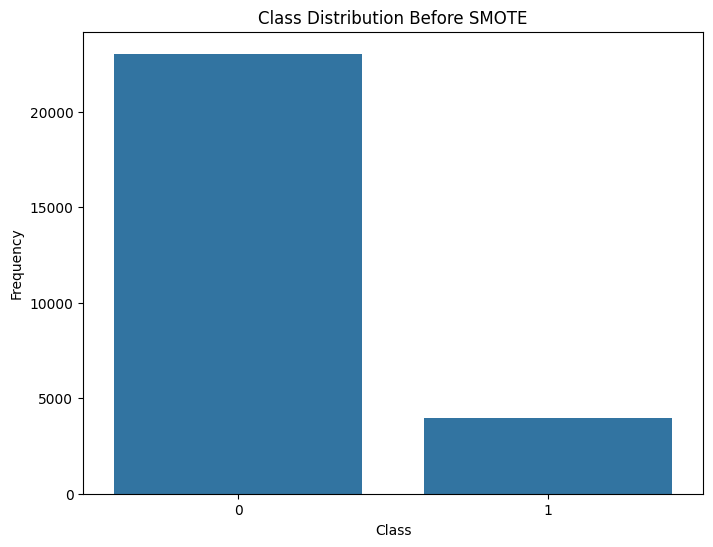

Class distribution:
loan_status
0    23026
1     3977
Name: count, dtype: int64


In [284]:
visualiseImbalanceData(y)

In [285]:
# Handle class imbalance using SMOTE [analyse whether data is imblance first]
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

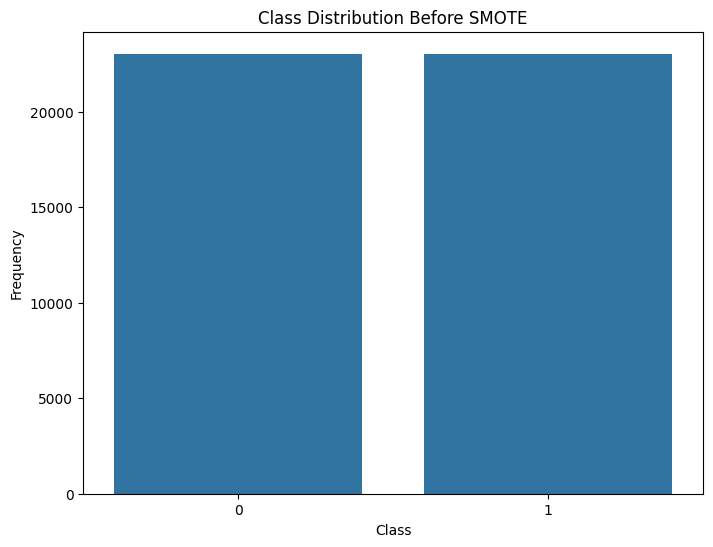

Class distribution:
loan_status
0    23026
1    23026
Name: count, dtype: int64


In [286]:
visualiseImbalanceData(y_resampled)

In [291]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [292]:
# Create a scaled version for models that require it (i.e. Logistic Regression)
X_train_lr = standardize_numerical_features(X_train.copy())
X_test_lr = standardize_numerical_features(X_test.copy())

In [293]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=4, learning_rate=0.1, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, depth=4, random_seed=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
}


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4617
           1       0.99      0.94      0.97      4594

    accuracy                           0.97      9211
   macro avg       0.97      0.97      0.97      9211
weighted avg       0.97      0.97      0.97      9211



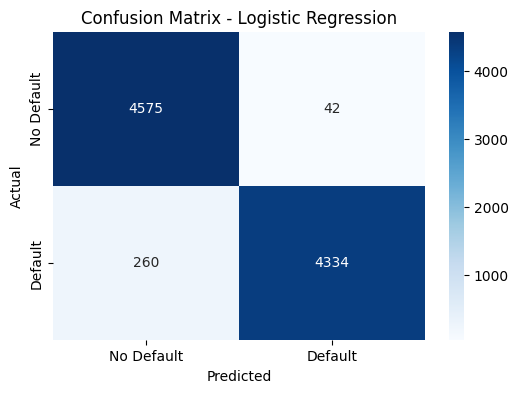


XGBoost Performance:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4617
           1       1.00      0.98      0.99      4594

    accuracy                           0.99      9211
   macro avg       0.99      0.99      0.99      9211
weighted avg       0.99      0.99      0.99      9211



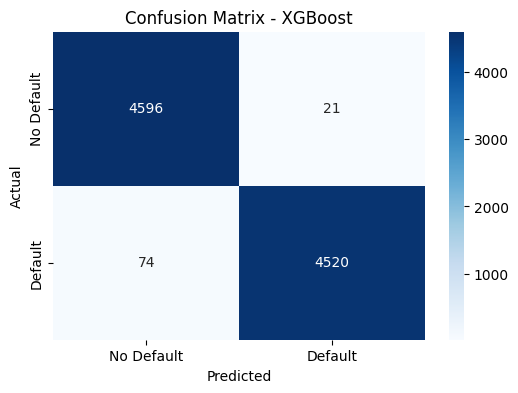


CatBoost Performance:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4617
           1       1.00      0.99      0.99      4594

    accuracy                           0.99      9211
   macro avg       0.99      0.99      0.99      9211
weighted avg       0.99      0.99      0.99      9211



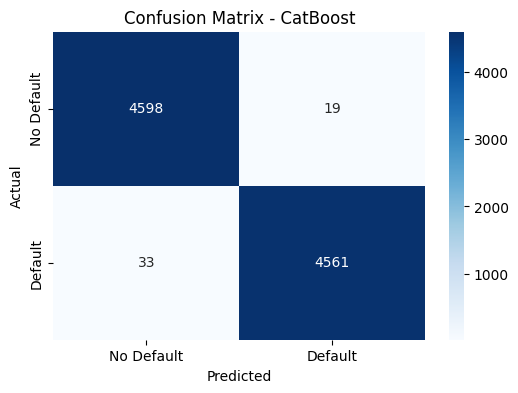


Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4617
           1       0.98      0.96      0.97      4594

    accuracy                           0.97      9211
   macro avg       0.97      0.97      0.97      9211
weighted avg       0.97      0.97      0.97      9211



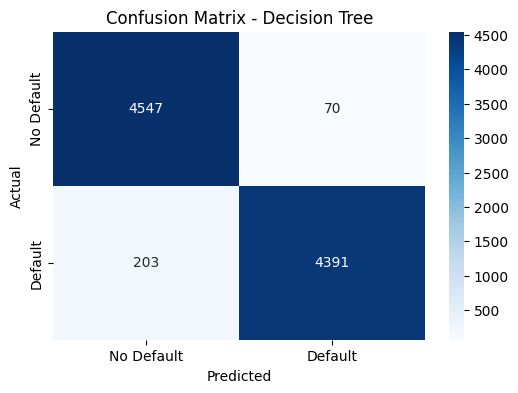


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4617
           1       1.00      0.91      0.95      4594

    accuracy                           0.96      9211
   macro avg       0.96      0.96      0.96      9211
weighted avg       0.96      0.96      0.96      9211



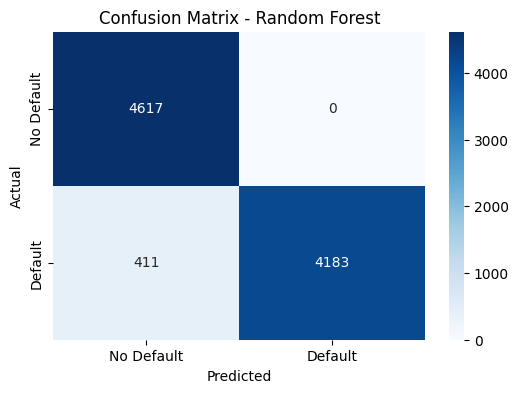


Comparison of Model Results:
                     Accuracy  Precision  Recall  F1-score     AUC  \
Logistic Regression    0.9672     0.9904  0.9434    0.9663  0.9959   
XGBoost                0.9897     0.9954  0.9839    0.9896  0.9995   
CatBoost               0.9944     0.9959  0.9928    0.9943  0.9998   
Decision Tree          0.9704     0.9843  0.9558    0.9699  0.9927   
Random Forest          0.9554     1.0000  0.9105    0.9532  0.9972   

                     Train Accuracy  Test Accuracy  Train AUC  Test AUC  
Logistic Regression          0.9681         0.9672     0.9944    0.9959  
XGBoost                      0.9904         0.9897     0.9995    0.9995  
CatBoost                     0.9963         0.9944     0.9999    0.9998  
Decision Tree                0.9728         0.9704     0.9933    0.9927  
Random Forest                0.9582         0.9554     0.9967    0.9972  


In [294]:
# Train and evaluate models
results = {}
# plt.figure(figsize=(8, 6))

for name, model in models.items():
    # For Logistic Regression, use the scaled dataset; for tree models, use the raw data.
    if name == "Logistic Regression":
        X_train_model = X_train_lr
        X_test_model = X_test_lr
    else:
        X_train_model = X_train
        X_test_model = X_test

    # Train the model
    model.fit(X_train_model, y_train)

    # Predictions on test data
    y_pred = model.predict(X_test_model)

    # Use predict_proba if available, otherwise decision_function
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_model)[:, 1]
        train_pred_proba = model.predict_proba(X_train_model)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test_model)
        train_pred_proba = model.decision_function(X_train_model)

    # Compute metrics and store them
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_pred_proba),
        "Train Accuracy": accuracy_score(y_train, model.predict(X_train_model)),
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Train AUC": roc_auc_score(y_train, train_pred_proba),
        "Test AUC": roc_auc_score(y_test, y_pred_proba)
    }

    # Print classification report for each model
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix for each model
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


# Create and display a table comparing model results
results_df = pd.DataFrame(results).T  # Transpose to have models as rows
results_df = results_df.round(4)      # Round metrics for readability

print("\nComparison of Model Results:")
print(results_df)